In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import streamlit as st
import plotly as pl
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pydeck as pdk
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3

sns.set_theme(palette="dark")

In [14]:
df = pd.read_csv(r"limited_query.csv")
df.rename(columns={"name_1": "Publisher", "title":"Journal Name"}, inplace=True)
print(df.columns)
# print(df.isnull().sum())
print(df.describe())
print(df.dtypes)

Index(['pubid', 'preferred', 'year', 'date', 'Journal Name', 'name',
       'Publisher', 'type', 'research_orgs', 'times_cited', 'recent_citations',
       'score', 'country', 'state', 'city', 'latitude', 'longitude',
       'country_code', 'state_code'],
      dtype='object')
              year   times_cited  recent_citations         score    latitude  \
count   500.000000    500.000000        500.000000    500.000000  500.000000   
mean   2020.450000   1466.456000       1465.444000  14129.596000   35.706717   
std       0.497992   4237.236319       4233.038353   5206.815365   21.868433   
min    2020.000000      0.000000          0.000000   9664.000000  -37.908298   
25%    2020.000000     53.000000         53.000000  10905.000000   32.877243   
50%    2020.000000    235.000000        235.000000  12621.500000   40.441942   
75%    2021.000000   1234.000000       1234.000000  15501.000000   51.453775   
max    2021.000000  26959.000000      26930.000000  36466.000000   63.821568   

 

In [15]:
# Change date to date_time
df['date'] = pd.to_datetime(df['date'])
df['month'] = pd.DatetimeIndex(df['date']).month
# Convert country code from 2 to 3 letter iso-3166-3 for use in plotly
df['country_code'] = df.country_code.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
df.dtypes

pubid                       object
preferred                   object
year                         int64
date                datetime64[ns]
Journal Name                object
name                        object
Publisher                   object
type                        object
research_orgs               object
times_cited                  int64
recent_citations             int64
score                        int64
country                     object
state                       object
city                        object
latitude                   float64
longitude                  float64
country_code                object
state_code                  object
month                        int64
dtype: object

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

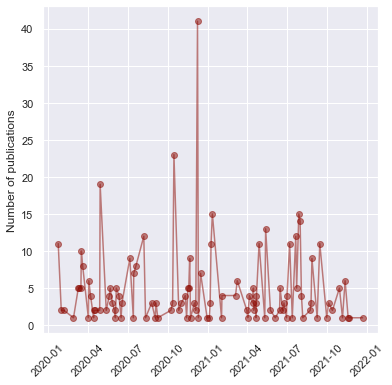

In [20]:
# Publication Line Plot
gdf_line = df.groupby(by="date").count() # Group by time
# Plot the publication could by date
fig_line, ax = plt.subplots(figsize=(6,6))
ax.plot(gdf_line.index,gdf_line.year, "r-o", alpha=0.5)
ax.set_ylabel('Number of publications')
plt.xticks(rotation=45)

In [26]:
# gdf_line.rename(columns={"pubid":"Publications"}).iloc[:,1]

pandas.core.series.Series

[]

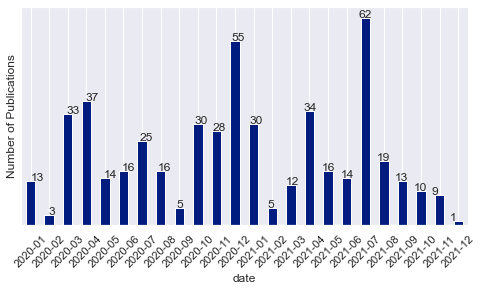

In [17]:
gdf = df.set_index('date').groupby(pd.Grouper(freq="M")).size()
gdf.index=gdf.index.map(lambda s: s.strftime('%Y-%m'))
fig, ax = plt.subplots(figsize=(8,4))
gdf.plot(kind="bar", ax=ax, rot=45)
ax.set_ylabel("Number of Publications")

x_ticks = ax.get_xticks()
for i,j in enumerate(x_ticks):
    ax.annotate(gdf[i],(j*.98,gdf[i]))
ax.get_yaxis().set_ticks([])

In [18]:
df.sort_values(by="name", axis=0)['name'].unique().size

333

Out of 500 returned values (so far) there are 332 unique organizations in this list

In [19]:
gdf_orgs=df.groupby(["name","latitude","longitude","country_code","country"]).agg({"pubid":'count',"score":'mean',"times_cited":"mean","recent_citations":"mean"}).sort_values(by="pubid",ascending=False).reset_index()
gdf_orgs.rename(columns={"pubid":"Publications"}, inplace=True)
gdf_orgs.head()


,name,latitude,longitude,country_code,country,Publications,score,times_cited,recent_citations
0,University of Oxford,51.753437,-1.254010,GBR,United Kingdom,15,14360.266667,443.266667,443.200000
1,Harvard University,42.377052,-71.116653,USA,United States,10,16055.100000,554.500000,554.300000
2,Imperial College London,51.498600,-0.175478,GBR,United Kingdom,7,13553.285714,558.571429,558.571429
3,Stanford University,37.430000,-122.169998,USA,United States,7,14910.428571,174.571429,174.571429
4,Tsinghua University,39.999584,116.325417,CHN,China,6,12964.333333,8030.500000,8024.333333


In [9]:
fig = px.scatter_geo(gdf_orgs,
                    lat='latitude', lon='longitude',hover_name="name",
                    color='country',size='Publications')
fig.show()

In [11]:
gdf_country = df.groupby(["country_code","country"]).agg({"pubid":'count',"score":'mean',"times_cited":"mean","recent_citations":"mean"}).sort_values(by="pubid",ascending=False).reset_index()
gdf_country.rename(columns={"pubid":"Publications"})

z_data = gdf_country['score']
fig = go.Figure(data=go.Choropleth(
    locations=gdf_country['country_code'],
    z = z_data,
    text=gdf_country["country"],
    colorscale="viridis",
    autocolorscale=True,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Data<br>'
))

fig.update_layout(
    title_text='COVID-19 Data by Country',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
     annotations = [dict(
        x=0.01,
        y=0.01,
        xref='paper',
        yref='paper',
        text='Source: https://console.cloud.google.com/marketplace/product/digitalscience-public/covid-19-dataset-dimensions?project=elite-caster-300319',
        showarrow = False
    )]
)
fig.show()
